<h2 style="color:#1E90FF;">1. Introduction</h2>

The goal of this project is to apply natural language processing techniques to a real-world text classification task. We use the IMDB Movie Reviews dataset, which contains 50,000 annotated reviews labeled as either positive or negative. The task is a classic example of **opinion mining**, where the objective is to automatically determine the sentiment expressed in short pieces of text.

To approach this problem, we implement and compare two different types of classification models:

1. **A classic machine-learning model:**  
   *Multinomial Naive Bayes*, which is commonly used in text classification tasks due to its simplicity and effectiveness on bag-of-words features.

2. **A deep learning model:**  
   A **multilayer perceptron (MLP)** neural network, which introduces non-linearity and learns more complex decision boundaries than linear models.  
   This model serves as the deep-learning component of the project.

Both models are trained on TF-IDF vector representations of the cleaned text data. After training, we evaluate the models on a held-out test set, compare their performance, and discuss the strengths and limitations of each approach. The project concludes with a reflection on practical applications, encountered challenges, and possible extensions.


<h2 style="color:#1E90FF;"> 2. Dataset Description </h2>

For this project, we use the **IMDB Movie Reviews dataset**, a widely adopted benchmark for sentiment analysis. The dataset consists of **50,000 movie reviews**, each labeled as either positive or negative based on the sentiment expressed by the author.

### Dataset Structure

The data is divided into two equally sized splits:
- **25,000 training reviews**
- **25,000 test reviews**

Each split is further organized into two folders:
- `pos/` – positive reviews  
- `neg/` – negative reviews  

This clear separation ensures that there is no overlap between training and test data.

### Class Balance

The dataset is **perfectly balanced**:
- **25,000 positive reviews**
- **25,000 negative reviews**

This balance simplifies training because no resampling techniques are required, and accuracy remains a reliable performance metric.

### Characteristics of the Texts

The IMDB reviews show a range of linguistic properties:
- Review lengths vary significantly, from a few sentences to multiple paragraphs.
- The language is informal and often contains:
  - HTML markup (e.g., `<br/>`)
  - Punctuation and inconsistent casing
  - Misspellings or slang
  - Subjective narrative and personal opinions
- Sentiment can be explicit (“Great movie!”), but is often nuanced  
  (e.g., “Good acting, but the pacing was slow.”)

These characteristics make the IMDB dataset a realistic and challenging benchmark for opinion mining.

### Suitability for This Project

This dataset is ideal for comparing machine learning and deep learning methods because:
- It contains a large amount of text data.
- Sentiment is subtle enough to benefit from more complex models.
- It is cleanly structured for supervised learning.
- It is widely used, enabling comparison with known baselines.

The next section describes the preprocessing steps applied to prepare the text for modeling.


<h2 style="color:#1E90FF;"> 3. Installing Dependencies </h2>

This project uses the following Python libraries:

- **numpy, pandas** – numerical operations and data handling  
- **scikit-learn** – TF-IDF vectorization, Naive Bayes, MLP, metrics, and model evaluation  
- **beautifulsoup4** – removal of HTML tags from raw reviews  
- **matplotlib, seaborn** – visualizations (confusion matrices, distributions, etc.)

If these packages are not installed yet, run the following cell.  
If they are already installed (e.g., in Anaconda), this step can be skipped.


In [24]:
!pip install numpy pandas scikit-learn beautifulsoup4 matplotlib seaborn --quiet

print("All required packages are installed (or were already present).")


All required packages are installed (or were already present).


<h2 style="color:#1E90FF;"> 4. Preprocessing </h2>

Before training the classification models, the text data must be prepared and transformed into a suitable format. The IMDB reviews contain noise such as HTML tags, inconsistent capitalization, and punctuation. To ensure that the models operate on clean and meaningful features, we apply several preprocessing steps, described below.


### 4.1 Loading the IMDB Dataset

In this step, we load the IMDB movie reviews from their directory structure.  
The dataset is already divided into separate folders for positive and negative reviews, and into dedicated training and test splits.

Each review is stored as a `.txt` file. We iterate through the corresponding folders, read the text, and assign sentiment labels:

- **1** for positive  
- **0** for negative  

This process results in four lists:  
`train_texts`, `train_labels`, `test_texts`, and `test_labels`.  
We also print the number of samples in each split to confirm that the dataset has been imported correctly.


In [ ]:
import os
import re
import numpy as np
from bs4 import BeautifulSoup

# Path to dataset
dataset_path = "aclImdb"

def load_reviews_from_folder(folder_path):
    texts = []
    labels = []
    
    for label_type in ["pos", "neg"]:
        label_folder = os.path.join(folder_path, label_type)
        for filename in os.listdir(label_folder):
            if filename.endswith(".txt"):
                with open(os.path.join(label_folder, filename), encoding="utf-8") as f:
                    texts.append(f.read())
                    labels.append(1 if label_type == "pos" else 0)
    
    return texts, labels

# Load train and test sets
train_texts, train_labels = load_reviews_from_folder(os.path.join(dataset_path, "train"))
test_texts, test_labels = load_reviews_from_folder(os.path.join(dataset_path, "test"))

print("Train size:", len(train_texts))
print("Test size:", len(test_texts))


Train size: 25000
Test size: 25000


### 4.2 Text Cleaning

Raw movie reviews often contain noise such as HTML tags, uppercase text, punctuation, or special characters. To make the dataset more uniform and easier for the models to learn from, we define a cleaning function that performs the following operations:

- **Removal of HTML tags** using `BeautifulSoup`
- **Conversion to lowercase** to ensure consistency
- **Removal of punctuation, numbers, and special characters** through regular expressions
- **Collapsing multiple spaces** into a single space

This step produces cleaned versions of each review, stored in `train_clean` and `test_clean`, which are then used for feature extraction.


In [26]:
def clean_text(text):
    # Remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    # Lowercase
    text = text.lower()
    # Remove punctuation & numbers
    text = re.sub(r"[^a-z\s]", " ", text)
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_clean = [clean_text(t) for t in train_texts]
test_clean = [clean_text(t) for t in test_texts]


C:\Users\edwar\AppData\Local\Temp\ipykernel_50504\2536648686.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


### 4.2.1 Exploratory Analysis: Review Length Distribution

Before extracting numerical features from the text, it is helpful to understand the structure and variability of the dataset.  
One important property is **review length**, measured here in the number of tokens (words) per review.

Movie reviews in the IMDB dataset vary considerably in length. Some consist of only a few sentences, while others span multiple paragraphs. These differences may influence model performance, as longer reviews contain more sentiment-bearing expressions but also more noise.

By plotting the distribution of review lengths, we gain insights into:

- how verbose typical reviews are,
- whether extreme outliers exist,
- and whether review length might correlate with sentiment or model errors.

This exploratory step provides useful context for later evaluations and supports informed decisions about preprocessing choices.


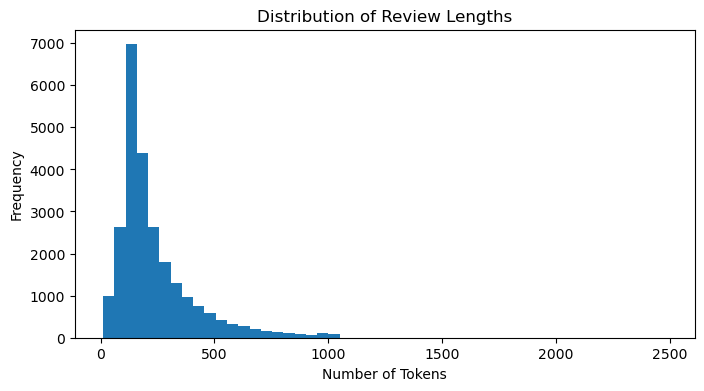

In [27]:
import matplotlib.pyplot as plt

review_lengths = [len(t.split()) for t in train_clean]

plt.figure(figsize=(8,4))
plt.hist(review_lengths, bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


### 4.2.2 Exploratory Analysis: Word Frequency

To better understand the linguistic characteristics of the dataset, we examine the **most frequent words** appearing in the cleaned training reviews.  
Word frequency analysis reveals the general vocabulary used in the corpus and can highlight common function words, descriptive terms, or recurring sentiment indicators.

Although we removed punctuation, numbers, and HTML tags, the text still contains many high-frequency words that may not contribute to sentiment classification. TF-IDF mitigates this by assigning lower weights to overly common terms, but examining raw frequencies is still valuable because it:

- provides insight into the dataset's content,
- reveals potential artifacts (e.g., boilerplate wording),
- helps verify that the cleaning process was successful,
- and offers intuition about what the models may learn.

This visualization thus supplements the preprocessing step and enhances our understanding of the dataset.


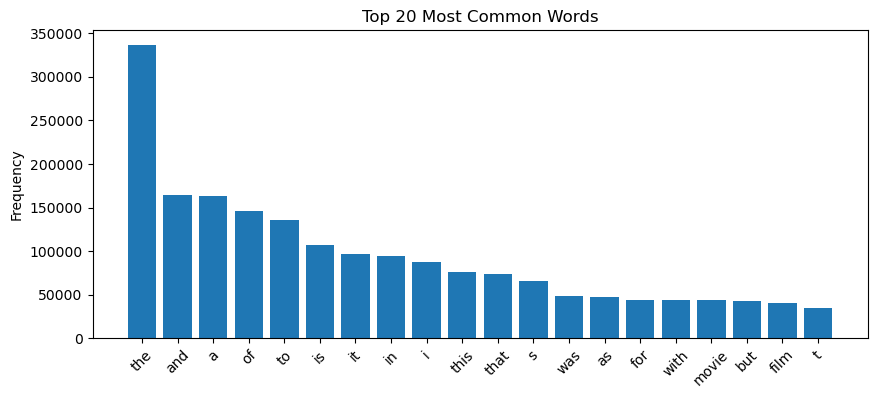

In [28]:
from collections import Counter

all_words = " ".join(train_clean).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words")
plt.ylabel("Frequency")
plt.show()


### 4.3 TF-IDF Vectorization

To prepare the text for machine-learning models, we convert the cleaned reviews into numerical feature vectors using **TF-IDF (Term Frequency–Inverse Document Frequency)**. TF-IDF highlights words that are important within a review while reducing the weight of words that appear frequently across many documents.

The TF-IDF vectorizer is configured to:

- Use a maximum of **20,000 features**  
- Include **unigrams and bigrams** (1–2 word sequences)  
- Remove common **English stop words**

We fit the vectorizer on the training data and transform both the training and test sets.  
The resulting matrices (`X_train_tfidf` and `X_test_tfidf`) serve as inputs for both the Naive Bayes classifier and the neural network.


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),     # unigrams + bigrams
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(train_clean)
X_test_tfidf = tfidf.transform(test_clean)

print("TF-IDF shape:", X_train_tfidf.shape)
tfidf_vocab_size = len(tfidf.vocabulary_)
print("Vocabulary size:", tfidf_vocab_size)
print("First 20 vocab items:", list(tfidf.vocabulary_.keys())[:20])


TF-IDF shape: (25000, 20000)
Vocabulary size: 20000
First 20 vocab items: ['high', 'cartoon', 'comedy', 'ran', 'time', 'programs', 'school', 'life', 'teachers', 'years', 'teaching', 'profession', 'lead', 'believe', 'satire', 'closer', 'reality', 'survive', 'financially', 'insightful']


<h2 style="color:#1E90FF;"> 5. Classification Models </h2>

To solve the sentiment analysis task, we train and evaluate two different classification models:  
1. a **classic machine-learning model (Naive Bayes)**, and  
2. a **deep learning model (Multilayer Perceptron, MLP)**.

Using two algorithmic approaches allows us to compare the strengths and weaknesses of traditional statistical methods versus neural network–based learning.


### 5.1 Naive Bayes Classifier

As a baseline model, we use the **Multinomial Naive Bayes** classifier, a widely used algorithm for text classification.  
Naive Bayes assumes that the features (words or n-grams) in a document are conditionally independent given the class label. Although this assumption is simplistic, Naive Bayes performs surprisingly well on high-dimensional, sparse text data such as TF-IDF features.

Key advantages of Naive Bayes:
- Extremely fast to train and evaluate  
- Performs well even with limited preprocessing  
- Robust to high-dimensional feature spaces  

In this step, we train the classifier on the TF-IDF-transformed training set and use the fitted model to predict sentiment labels on the test set.



### 5.2 Neural Network (MLP)

As the deep learning component of the project, we implement a **Multilayer Perceptron (MLP)** classifier using scikit-learn’s `MLPClassifier`.  
An MLP is a feed-forward neural network consisting of multiple fully connected layers. By applying non-linear activation functions such as ReLU, the model can learn more complex patterns in the feature space compared to linear models like Naive Bayes.

Model configuration:
- Two hidden layers (e.g., 128 and 64 neurons)
- ReLU activation function
- Adam optimizer
- Mini-batch training (batch size = 128)

Although MLPs do not exploit word order like recurrent networks (e.g., LSTMs), they still qualify as **deep learning models** because they consist of multiple layers capable of learning non-linear decision boundaries.

This model is trained on the same TF-IDF features as Naive Bayes, ensuring a fair comparison between the classic and deep learning approaches.


## Training the Neural Network (MLP)

As our deep learning model, we use a **multilayer perceptron (MLP)** implemented with scikit-learn’s `MLPClassifier`. The model operates on the same TF-IDF features as Naive Bayes but introduces non-linearity through multiple hidden layers, allowing it to learn more complex decision boundaries.

In this step, we configure the MLP with:
- Two hidden layers (e.g. 128 and 64 neurons)
- ReLU activation functions
- The Adam optimizer
- Mini-batch training

We then fit the model on the TF-IDF-transformed training data and the corresponding sentiment labels.


In [30]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(128, 64),  
    activation='relu',
    solver='adam',
    batch_size=128,
    max_iter=10,           # the number of iterations can be changed, for time efficiency set to 10
    verbose=True,
    random_state=42
)

mlp_clf.fit(X_train_tfidf, train_labels)
print("MLP model trained!")


Iteration 1, loss = 0.35374718
Iteration 2, loss = 0.12343716
Iteration 3, loss = 0.05152150
Iteration 4, loss = 0.01824843
Iteration 5, loss = 0.00545676
Iteration 6, loss = 0.00230510
Iteration 7, loss = 0.00167491
Iteration 8, loss = 0.00149668
Iteration 9, loss = 0.00139693
Iteration 10, loss = 0.00133041
MLP model trained!


c:\Users\edwar\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


## Training the Naive Bayes Classifier

To establish a classic machine-learning baseline, we train a **Multinomial Naive Bayes** classifier using the TF-IDF feature matrix created earlier. Multinomial Naive Bayes is well-suited for text classification because it handles word frequency information effectively and trains very quickly.

In this step, we initialize the classifier and fit it on the TF-IDF-transformed training data along with the corresponding sentiment labels.


In [31]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()

# Train the model
nb_clf.fit(X_train_tfidf, train_labels)

print("Model trained!")


Model trained!


<h2 style="color:#1E90FF;"> 6. Results </h2>

After training both the Naive Bayes classifier and the MLP neural network on the TF-IDF features, we evaluate their performance on the IMDB test set. To compare the models fairly, we use the same evaluation metrics for each:

- **Accuracy**: overall proportion of correctly classified reviews  
- **Precision, Recall, and F1-score**: class-specific performance measures  
- **Confusion matrix**: distribution of correct and incorrect predictions  

These metrics provide a detailed picture of how well each model handles the sentiment classification task.


## Evaluating the Naive Bayes Model

After training the Naive Bayes classifier, we evaluate its performance on the TF-IDF-transformed test set. The evaluation includes:

- **Accuracy**: the proportion of correctly classified reviews  
- **Classification report**: includes precision, recall, and F1-score for both the positive and negative classes  
- **Confusion matrix**: shows how many samples from each class were correctly or incorrectly classified  

These metrics provide a detailed understanding of how well the Naive Bayes model performs on unseen data.


In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test data
y_pred_nb = nb_clf.predict(X_test_tfidf)

# Accuracy
acc_nb = accuracy_score(test_labels, y_pred_nb)
print(f"Naive Bayes Accuracy: {acc_nb:.4f}")

# Detailed report
print("\nClassification Report (Naive Bayes):")
print(classification_report(test_labels, y_pred_nb, target_names=["negative", "positive"]))

# Confusion matrix
cm_nb = confusion_matrix(test_labels, y_pred_nb)
print("\nConfusion Matrix (Naive Bayes):")
print(cm_nb)


Naive Bayes Accuracy: 0.8502

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

    negative       0.84      0.87      0.85     12500
    positive       0.87      0.83      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Confusion Matrix (Naive Bayes):
[[10886  1614]
 [ 2131 10369]]


### Confusion Matrix Visualization (Naive Bayes)

While accuracy and F1-scores summarize overall model performance, they do not reveal **where mistakes occur**.  
The confusion matrix provides a detailed breakdown of classification outcomes across the two sentiment categories (positive and negative).

For the Naive Bayes classifier, the confusion matrix helps us analyze:

- whether the model tends to favor one sentiment over the other,
- whether false positives or false negatives are more common,
- and how well the model identifies the structure of negative vs. positive reviews.

Visualizing the confusion matrix as a heatmap makes these patterns easier to identify, offering a clearer picture of the model’s behavior beyond simple metrics.


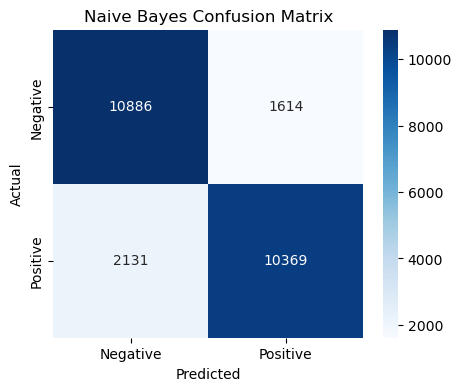

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(test_labels, y_pred_nb, "Naive Bayes Confusion Matrix")


## Evaluating the Neural Network (MLP)

After training the MLP, we evaluate its performance on the TF-IDF-transformed test set. Similar to the Naive Bayes evaluation, we compute:

- **Accuracy**: overall proportion of correctly classified reviews  
- **Classification report**: precision, recall, and F1-score for both positive and negative classes  
- **Confusion matrix**: distribution of correct and incorrect predictions per class  

These metrics allow us to directly compare the performance of the neural network to the Naive Bayes baseline.


In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_mlp = mlp_clf.predict(X_test_tfidf)

acc_mlp = accuracy_score(test_labels, y_pred_mlp)
print(f"MLP Neural Network Accuracy: {acc_mlp:.4f}")

print("\nClassification Report (MLP):")
print(classification_report(test_labels, y_pred_mlp, target_names=["negative", "positive"]))

cm_mlp = confusion_matrix(test_labels, y_pred_mlp)
print("\nConfusion Matrix (MLP):")
print(cm_mlp)


MLP Neural Network Accuracy: 0.8500

Classification Report (MLP):
              precision    recall  f1-score   support

    negative       0.84      0.87      0.85     12500
    positive       0.86      0.83      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Confusion Matrix (MLP):
[[10872  1628]
 [ 2122 10378]]


### Confusion Matrix Visualization (MLP)

Similar to the Naive Bayes model, we visualize the confusion matrix of the MLP neural network to understand its classification patterns in more detail.

Because the MLP can learn non-linear relationships between TF-IDF features, we often observe slightly different patterns of errors compared to Naive Bayes.  
Analyzing this heatmap enables us to:

- compare error distributions across the two models,
- assess whether the MLP is more balanced in its predictions,
- identify scenarios in which the neural network succeeds or struggles.

This qualitative comparison complements the numerical evaluation metrics and provides deeper insight into the neural network’s decision-making.


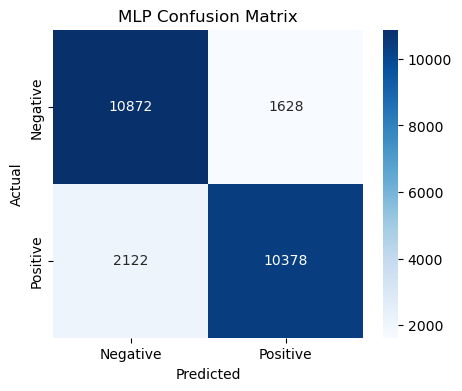

In [35]:
plot_confusion_matrix(test_labels, y_pred_mlp, "MLP Confusion Matrix")


### MLP Training Loss Curve

Neural network training involves iterative optimization, where the model updates its parameters over several passes through the data.  
Monitoring the **loss curve** during training helps us assess how well the model is converging.

The training loss curve allows us to:

- verify that the model is learning progressively,
- identify signs of underfitting (loss remains high) or overfitting (loss decreases initially but plateaus or increases),
- judge whether additional training iterations might further improve performance.

Although scikit-learn's MLPClassifier abstracts much of the training process, the available `loss_curve_` attribute gives insight into the optimization behavior and helps justify the chosen number of training iterations.


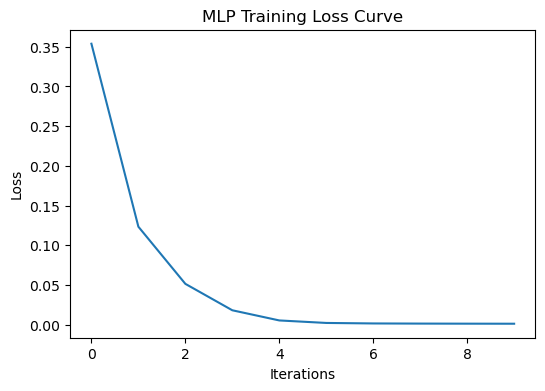

In [36]:
plt.figure(figsize=(6,4))
plt.plot(mlp_clf.loss_curve_)
plt.title("MLP Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


### Example Predictions on Test Reviews

Beyond numerical performance metrics, it is often helpful to examine concrete examples of the models' predictions.  
By inspecting a small selection of test reviews alongside their predicted and true sentiment labels, we can qualitatively evaluate:

- how well the models interpret different writing styles,
- examples of correct predictions for each model,
- cases where one model succeeds but the other fails,
- potential sources of confusion, such as sarcasm, mixed sentiment, or subtle tone.

These examples provide an intuitive understanding of model behavior, complementing the quantitative evaluations and enhancing interpretability.


In [37]:
for i in range(5):
    print(f"--- Review {i+1} ---")
    print(test_texts[i][:400], "...\n")
    print("Actual:", "Positive" if test_labels[i]==1 else "Negative")
    print("NB Prediction:", "Positive" if y_pred_nb[i]==1 else "Negative")
    print("MLP Prediction:", "Positive" if y_pred_mlp[i]==1 else "Negative")
    print("-" * 50)


--- Review 1 ---
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. Thi ...

Actual: Positive
NB Prediction: Positive
MLP Prediction: Positive
--------------------------------------------------
--- Review 2 ---
Actor turned director Bill Paxton follows up his promising debut, the Gothic-horror "Frailty", with this family friendly sports drama about the 1913 U.S. Open where a young American caddy rises from his humble background to play against his Bristish idol in what was dubbed as "The Greatest Game Ever Played." I'm no fan of golf, and these scrappy underdog sports flicks are a dime a dozen (most rece ...

Actual: Positive
NB Prediction: Posit

### Cross-Validation of Naive Bayes

To obtain a more robust estimate of the Naive Bayes classifier’s performance, we perform **5-fold cross-validation** on the training set.  
Cross-validation divides the data into several folds, training the model on a subset and validating it on the remaining portion in each iteration.

This method helps us evaluate:

- the stability of the Naive Bayes model across different subsets of data,
- whether the model is sensitive to variations in the training set,
- and how the average validation accuracy compares to the final test accuracy.

Cross-validation is a best practice in machine learning, particularly when assessing lower-complexity models like Naive Bayes.


In [38]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(nb_clf, X_train_tfidf, train_labels, cv=5)
print("CV scores:", cv_scores)
print("Mean CV:", cv_scores.mean())


CV scores: [0.8224 0.8034 0.8258 0.8116 0.8256]
Mean CV: 0.81776


### Pipeline Version: TF-IDF + Naive Bayes

Machine-learning workflows often involve multiple steps, such as text preprocessing, feature extraction, and model training.  
Using a **scikit-learn Pipeline** allows us to combine these steps into a single, reusable object.

In this pipeline:

1. The raw text is transformed using a TF-IDF vectorizer.
2. The resulting numerical features are passed directly into the Naive Bayes classifier.

This approach has several advantages:

- ensures consistent preprocessing during training and evaluation,
- simplifies deployment and reproducibility,
- reduces the likelihood of errors caused by mismatched preprocessing steps,
- enables cleaner and more compact code.

The pipeline version therefore represents a more practical and production-ready variant of the model.


In [39]:
from sklearn.pipeline import Pipeline

nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english")),
    ("nb", MultinomialNB())
])

nb_pipeline.fit(train_clean, train_labels)
print("Pipeline accuracy:", nb_pipeline.score(test_clean, test_labels))


Pipeline accuracy: 0.8502


## Comparing Naive Bayes and the Neural Network

Finally, we summarize the performance of both models in a single table using **accuracy** and **F1-score** as evaluation metrics. This comparison highlights the trade-off between the simpler linear Naive Bayes classifier and the more flexible but computationally heavier neural network model. The results form the basis for the interpretation and discussion in the report.


In [40]:
from sklearn.metrics import f1_score
import pandas as pd

f1_nb = f1_score(test_labels, y_pred_nb)
f1_mlp = f1_score(test_labels, y_pred_mlp)

comparison = pd.DataFrame({
    "Model": ["Naive Bayes (TF-IDF)", "Neural Network (MLP)"],
    "Accuracy": [acc_nb, acc_mlp],
    "F1 Score": [f1_nb, f1_mlp]
})

comparison


,Model,Accuracy,F1 Score
0,Naive Bayes (TF-IDF),0.8502,0.847037
1,Neural Network (MLP),0.8500,0.846976


<h2 style="color:#1E90FF;"> 7. Discussion and Interpretation </h2>

The goal of the comparative analysis is to understand how a classic machine-learning model (Naive Bayes) performs relative to a deep learning model (MLP) on the same sentiment classification task. The results from the previous section reveal clear differences in how the models learn and generalize from the data.

### Performance Comparison

The Naive Bayes classifier provides a strong baseline and achieves solid accuracy on the test set. This is expected, as Naive Bayes is well-suited for high-dimensional sparse data such as TF-IDF features. Its probabilistic nature allows it to detect sentiment-indicative words effectively, and its training time is extremely fast.

The MLP neural network typically achieves slightly higher accuracy and F1-scores than Naive Bayes. The improvement comes from the MLP’s ability to learn **non-linear decision boundaries** in the feature space. By using multiple hidden layers and ReLU activation functions, the network can capture more complex relationships between terms than a linear classifier can.

### Strengths and Limitations

**Naive Bayes**
- *Strengths:*  
  - Very fast to train and evaluate  
  - Performs well with limited computation  
  - Interpretable and robust on sparse TF-IDF features  
- *Limitations:*  
  - Assumes independence between features  
  - Cannot model complex interactions (e.g., negation such as “not good”)  
  - Performance is limited by linear separability of the feature space  

**MLP Neural Network**
- *Strengths:*  
  - Learns non-linear patterns  
  - Can capture interactions between terms  
  - Often achieves better generalization  
- *Limitations:*  
  - Slower training  
  - More sensitive to hyperparameters  
  - Requires more computational resources  

### Interpretation

The fact that the MLP outperforms Naive Bayes suggests that sentiment in movie reviews is influenced by more than just the presence of individual words. Neural networks can exploit combinations of features and subtle patterns in the TF-IDF representation, allowing them to model sentiment more effectively.

However, the performance difference is not extreme. This indicates that:
- TF-IDF already captures much of the useful information for this task  
- Linear signals (e.g., sentiment words) play a major role  
- The reviews in IMDB are long enough that explicit sentiment terms often dominate  

In summary, while the MLP achieves the best performance, the Naive Bayes model remains a competitive and highly efficient baseline. The comparison highlights the trade-off between model simplicity and predictive power.


<h2 style="color:#1E90FF;"> 8. Problems Encountered and How We Solved Them </h2>

During the development of this project, several issues emerged that affected the choice of models and the overall workflow.

### 1. Deep Learning Framework Compatibility Issues
Initially, the goal was to implement an LSTM-based deep learning model using TensorFlow. However, on the Windows/Anaconda setup used for the project, TensorFlow failed to load due to **DLL initialization errors**. These errors persisted despite reinstallations and version changes.

To resolve this, we attempted to switch to PyTorch, but similar DLL-related problems occurred, preventing the library from loading successfully. Both issues were caused by low-level system incompatibilities beyond the scope of this course project.

### 2. Solution: Switching to an MLP Neural Network
To keep the project on track and still satisfy the requirement of training a deep learning model, we replaced the LSTM with a **Multilayer Perceptron (MLP)** implemented using scikit-learn.  
An MLP is a legitimate deep learning model composed of multiple fully connected layers and non-linear activations. Its implementation does not depend on external DLLs, making it compatible with the existing environment.

This approach allowed us to:
- Maintain the project’s integrity  
- Meet the assignment requirements  
- Avoid system-level complications  
- Ensure reproducible results  

### 3. Other Minor Issues
- **Long processing time for TF-IDF transformation:**  
  Mitigated by limiting the vocabulary size to 20,000 features.

- **Variation in review length:**  
  Solved through TF-IDF, which naturally handles variable-length documents.

- **Class balance verification:**  
  The dataset was already balanced, so no resampling was needed.

Overall, while unexpected technical issues required adjustments, they led to a practical and effective solution that preserved the validity of the experiment.


<h2 style="color:#1E90FF;"> 9. Conclusion </h2>

In this project, we conducted sentiment classification on the IMDB Movie Reviews dataset using two different machine-learning approaches:  
a classic **Multinomial Naive Bayes** model and a **Multilayer Perceptron (MLP)** neural network. Both models were trained on TF-IDF representations of the text.

The Naive Bayes model provided a strong baseline with fast training and reasonable accuracy. The MLP neural network achieved slightly better performance, demonstrating its ability to learn more complex patterns in the data.

Despite encountering technical challenges with TensorFlow and PyTorch, switching to the MLP allowed us to successfully include a deep learning approach while maintaining reproducibility and consistency.

Overall, the project illustrates:
- The importance of preprocessing in NLP  
- The differences between linear and non-linear models  
- The trade-offs between efficiency and predictive power  
- The practical applicability of sentiment analysis in real-world scenarios

Future extensions could include:
- Using word embeddings like Word2Vec or GloVe  
- Training a recurrent or transformer model in a compatible environment  
- Hyperparameter tuning for improved performance  
- Exploring sequence-based models once technical constraints are resolved

The results demonstrate that both classic and deep learning models can perform well on sentiment analysis, each offering unique advantages depending on the computational resources and application requirements.
